# 오차역전파법(backpropagation)
## 계산 그래프
- 계산과정을 그래프로 나타낸 것
- 구성: 복수의 노드와 에지
- 문제풀이 과정
  - 계산 그래프를 구성한다.
  - 그래프에서 계산을 왼쪽에서 오른쪽으로 진행한다.
- 개념
  - 순전파(foward propagation): 계산을 왼쪽에서 오른쪽으로 진행하는 단계
  - 역전파(backward propagation) 반대방향, 즉 계산을 오른쪽에서 왼쪽으로 진행하는 단계
ex) 노드와 계산 결과를 계산 그래프로 그렸을 때
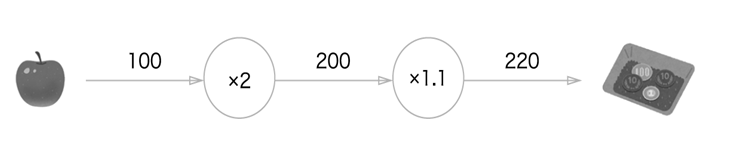

ex2) 계산 그래프에서 사과의 개수와 소비세를 변수로 취급하는 경우
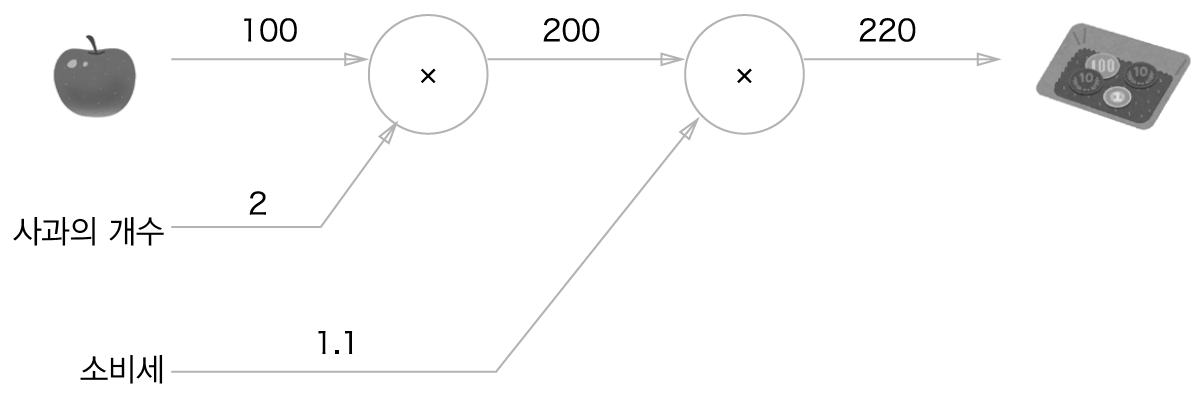


- 계산 그래프의 특징은 '국소적 계산'을 전파함으로써 최종 결과를 얻는다.
  - 국소적이란 날은 '자신과 직접 관계된 작은 범위'라는 의미
  - 즉 전체를 신경쓰지 않고 자신과 관계된 정보만으로 결과를 출력할 수 있다.
- 계산그래프로 푸는 이유
  - 중간 계산 결과를 모두 보관할 수 있다.
  - 역전파를 통해 '미분'을 효율적으로 계산할 수 있다.

## 연쇄법칙
- '국소적 미분'을 전달하는 원리이다.
- 역전파의 계산 절차는 신호 E에 노드의 국소적 미분($\frac{\partial y}{\partial x}$)을 곱한 후 다음 노드로 전달한다.
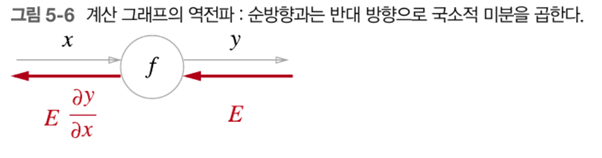
- 합성함수: 여러 함수로 구성된 함수
- 연쇄법칙은 합성 함수의 미분에 대한 성질이다.
  - 합성 함수의 미분은 합성 함수를 구성하는 각 함수의 미분의 곱으로 나타낼 수 있다.
- 역전파의 계산절차: 노드로 들어온 입력 신호에 그 노드의 국소적 미분(편미분)을 곱한 후 다음 노드로 전달

## 역전파
### 덧셈 노드의 역전파
- z = x + y 기준
- 덧셈 노드 역전파는 입력 신호를 다음 노드로 출력한다.
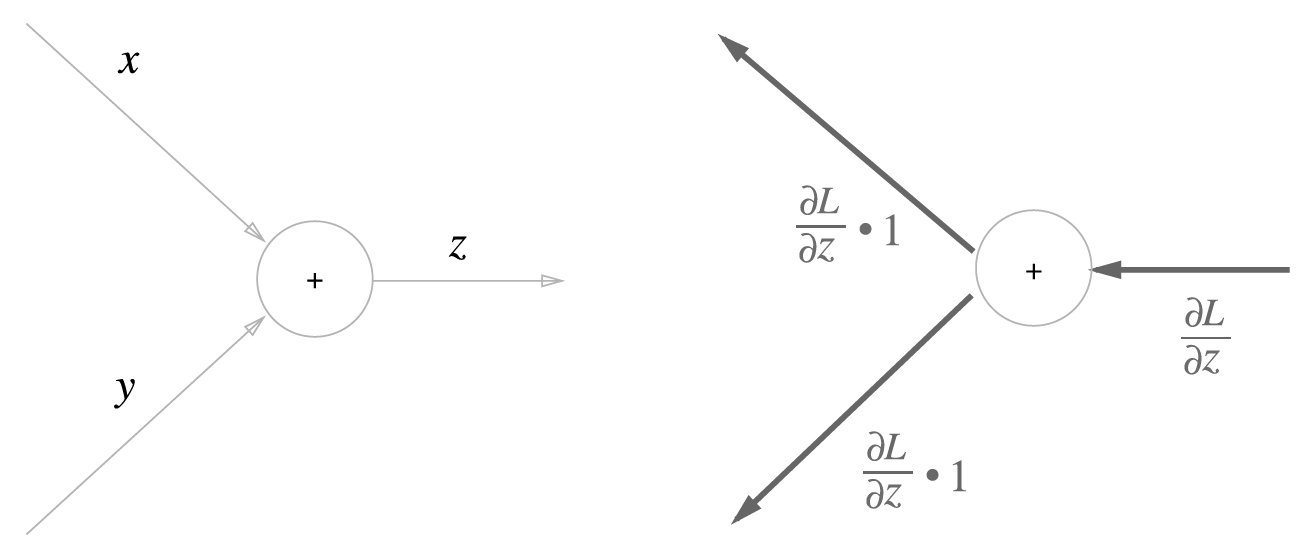

### 곱셈노드의 역전파
- z = xy 기준
- 상류의 값에 순전파 때의 입력 신호들을 '서로 바꾼 값'을 곱해서 하류로 보낸다.
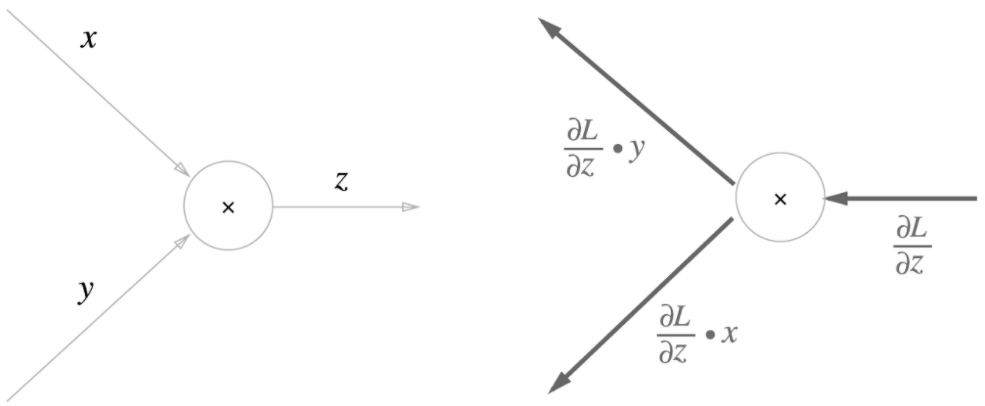

## 단순한 계층 구현하기
### 곱셈 계층

In [23]:
class MulLayer:
  def __init__(self):
    self.x = None
    self.y = None

  def forward(self, x, y):
    self.x = x
    self.y = y
    out = x * y

    return out


  def backward(self, dout):
    dx = dout * self.y
    dy = dout * self.x

    return dx, dy

In [24]:
apple = 100
apple_num = 2
tax = 1.1

#계층들
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

#순전파
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print("--- 순전파의 결과값 ---")
print(price)

#역전파
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print("--- 역전파의 결과값 ---")
print(dapple, dapple_num, dtax)

--- 순전파의 결과값 ---
220.00000000000003
--- 역전파의 결과값 ---
2.2 110.00000000000001 200


### 덧셈 계층

In [25]:
class AddLayer:
  def __init__(self):
    pass

  def forward(self, x, y):
    out = x + y
    return out

  def backward(self, dout):
    dx = dout * 1
    dy = dout * 1
    return dx, dy

In [26]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)  # (1)
orange_price = mul_orange_layer.forward(orange, orange_num)  # (2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)  # (3)
price = mul_tax_layer.forward(all_price, tax)  # (4)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)  # (4)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)  # (3)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)  # (2)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)  # (1)

print("---순전파---")
print("price:", int(price))
print("---역전파---")
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dOrange:", dorange)
print("dOrange_num:", int(dorange_num))
print("dTax:", dtax)

---순전파---
price: 715
---역전파---
dApple: 2.2
dApple_num: 110
dOrange: 3.3000000000000003
dOrange_num: 165
dTax: 650


## 활성화 함수 계층 구현하기
### ReLU 계층
- 수식 엿보기
$$ y = \begin{cases} x & \text{if x > 0} \\ 0 & \text{if x $\leq$ 0} \end{cases} $$

- x에 대한 미분
$$ \frac{\partial y}{\partial x} = \begin{cases} 1 & \text{if x > 0} \\ 0 & \text{if x $\leq$ 0} \end{cases} $$

- 계산 그래프
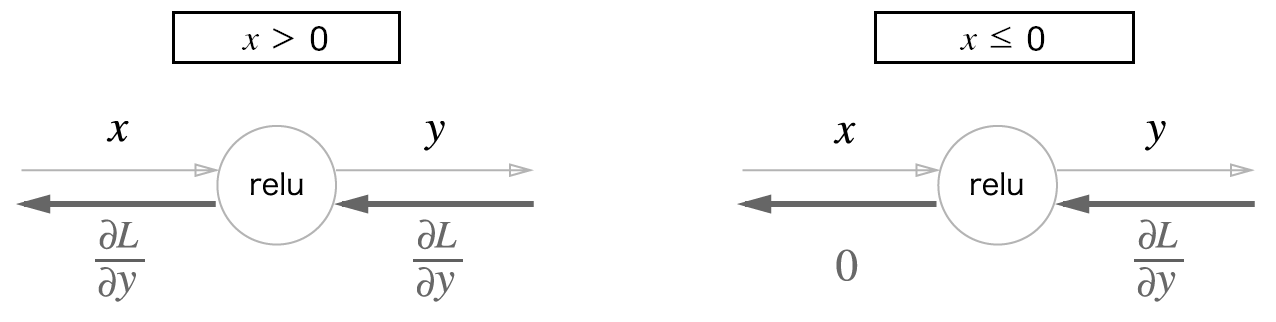

In [27]:
class Relu:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0

    return out

  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout

    return dx

In [28]:
import numpy as np
x = np.array([[1.0, -9.5], [-2.0, 3.0]])
print('---배열 확인---')
print(x)
mask = (x <= 0)
print('---ReLu 값 확인---')
print(mask)

---배열 확인---
[[ 1.  -9.5]
 [-2.   3. ]]
---ReLu 값 확인---
[[False  True]
 [ True False]]


### Sigmoid 계층
- 수식 엿보기
$$ y = \frac{1}{1+exp(-x)} $$
- 계산 그래프
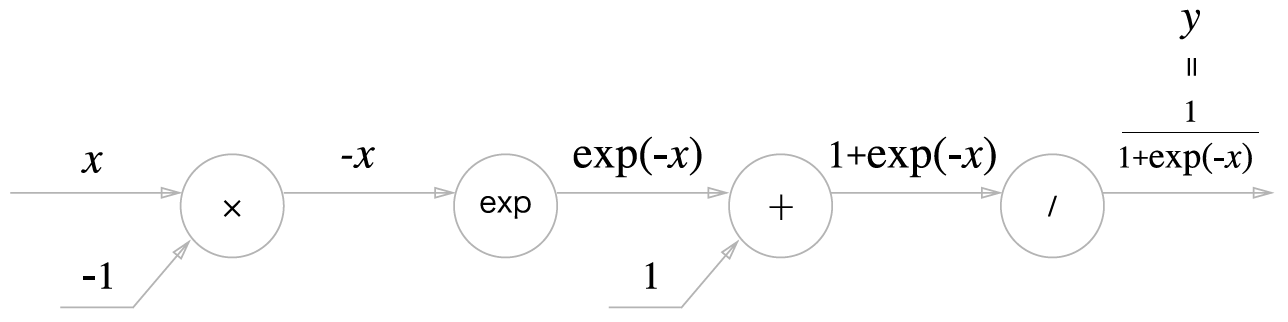

- **단계별 살펴보기**
  - 1단계: 역전파 때는 상류에서 흘러운 값에 $-y^2$를 곱해서 하류로 전달한다.
  $$ \frac{∂y}{∂x} = - \frac{1}{x^2} = - y^2 $$
  - 2단계: '+'노드는 상류의 값을 여과없이 하류로 내보낸다.
  - 3단계: 'exp'노드는 y = exp(x) 연산을 수행. 상류의 값에 순전파 때의 출력을 곱해 하류로 전파한다.
  $$ \frac{∂y}{∂x} = exp(x) $$
  - 4단계: '×'노드는 순전파 때의 값을 '서로 바꿔' 곱한다.
  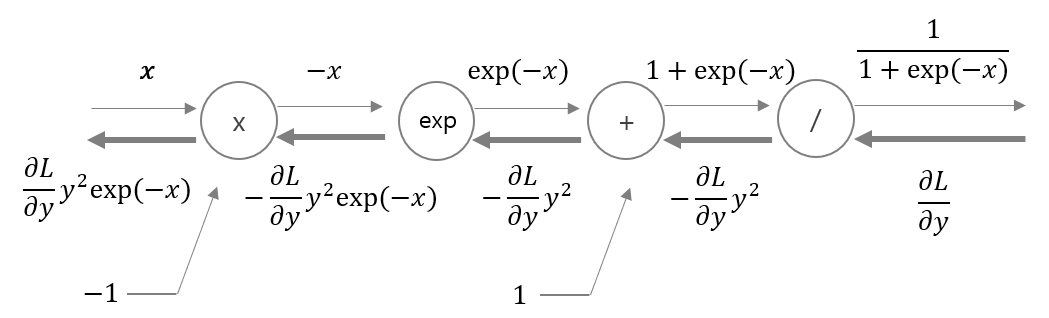

- 간소화 버전


  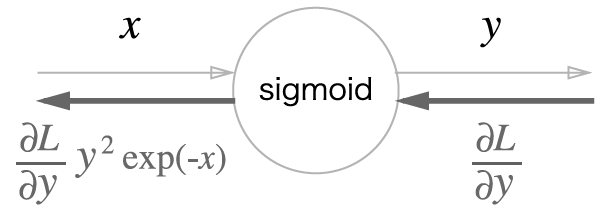

In [29]:
class Sigmoid:
  def __init__(self):
    self.out = None

  def forward(self, x):
    out = 1 / (1+np.exp(-x))
    self.out = out

    return out

  def backward(self, dout):
    dx = dout * (1.0 - self.out) * self.out

    return dx

In [30]:
sigmoid_layer = Sigmoid()

# 순전파 예시
x = np.array([1.0, 2.0, 3.0])
print("Input:", x)
forward_output = sigmoid_layer.forward(x)
print("Forward Output:", forward_output)

# 역전파 예시
dout = np.array([1.0, 1.0, 1.0])  # 예시로 1로 초기화
backward_output = sigmoid_layer.backward(dout)
print("Backward Output:", backward_output)

Input: [1. 2. 3.]
Forward Output: [0.73105858 0.88079708 0.95257413]
Backward Output: [0.19661193 0.10499359 0.04517666]


## Affine/Softmax 계층 구현하기
### Affine 계층
- 신경망의 순전파에서 가중치 신호의 총합 계산 방식
- 계산 그래프

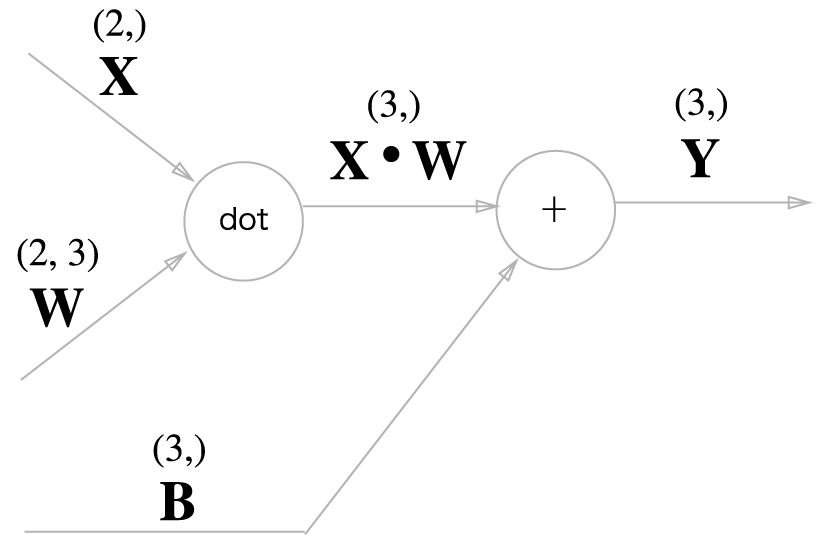

In [31]:
x = np.random.rand(2) #입력
w = np.random.rand(2,3) #가중치
b = np.random.rand(3) #편향

print(x.shape)
print(w.shape)
print(b.shape)

y = np.dot(x, w) + b

(2,)
(2, 3)
(3,)


- 역전파 식
$$ \frac{∂L}{∂X} = \frac{∂L}{∂Y} * W^T $$
$$ \frac{∂L}{∂X} = X^T * \frac{∂L}{∂Y} $$
- 전치 행렬 수식으로 표현
$$ W =  
\begin{pmatrix}
w_{11} & w_{12} & w_{13} \\
w_{21} & w_{22} & w_{23}
\end{pmatrix} $$

$$ W^T =
\begin{pmatrix}
w_{11} & w_{21} \\
w_{12} & w_{22} \\
w_{13} & w_{23}
\end{pmatrix} $$

- 결과 그림
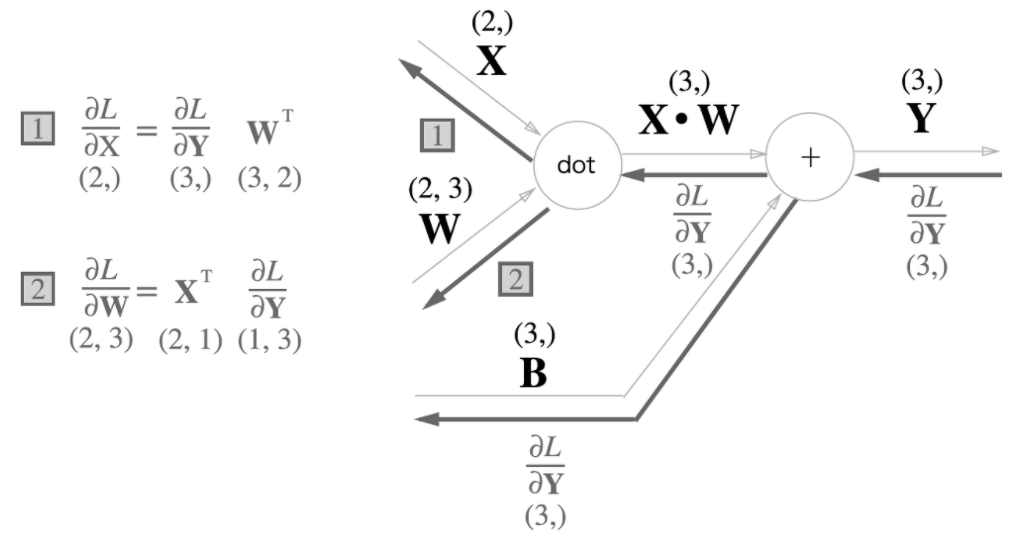

### 배치용 Affine 계층
- 기존의 Affine 계층은 입력 데이터로 X 하나만 고려함
- 배치용 Affine 계층은 데이터 N개를 묶어서 순전파한다.

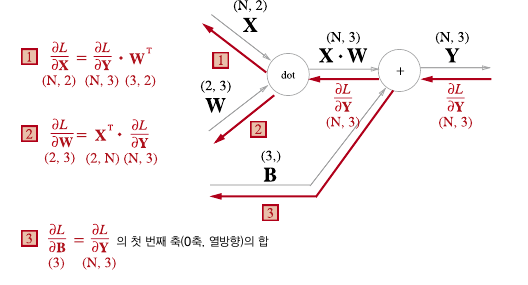

- 순전파의 편향 덧셈

In [32]:
X_dot_W = np.array([[0,0,0], [10,10,10]])
B = np.array([1,2,3])

print(X_dot_W)
print(X_dot_W + B)

[[ 0  0  0]
 [10 10 10]]
[[ 1  2  3]
 [11 12 13]]


- 역전파의 편향 덧셈

In [33]:
dY = np.array([[1,2,3], [4,5,6]])
print(dY)
print('---')
dB = np.sum(dY, axis=0)
print(dB)

[[1 2 3]
 [4 5 6]]
---
[5 7 9]


- Affine 구현

In [34]:
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.dW = None
    self.db = None

  def forward(self, x):
    self.x = x
    out = np.dot(x, self.W) + self.b

    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T)
    self.db= np.sum(dout,axis = 0)

    return dx

### Softmax-with-Loss 계층
- 소프트맥스 함수는 입력 값을 정규화해서 출력한다.
- 소프트맥스 계층 구현 시 손실 함수인 교차 엔트로피 오차도 포함한다.
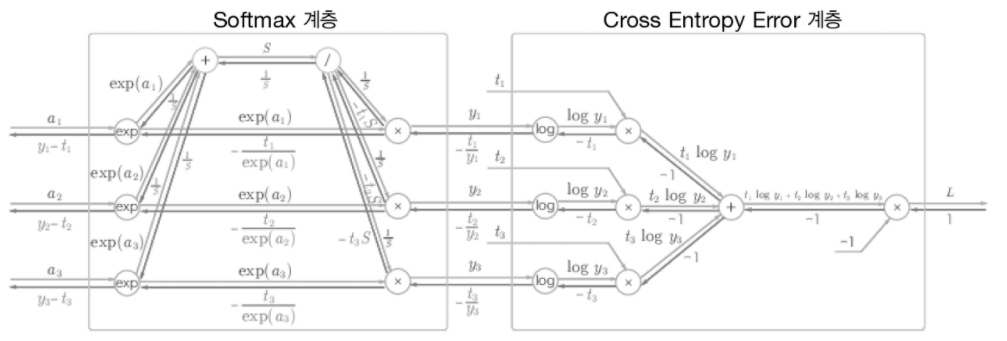

- 간소화 버전

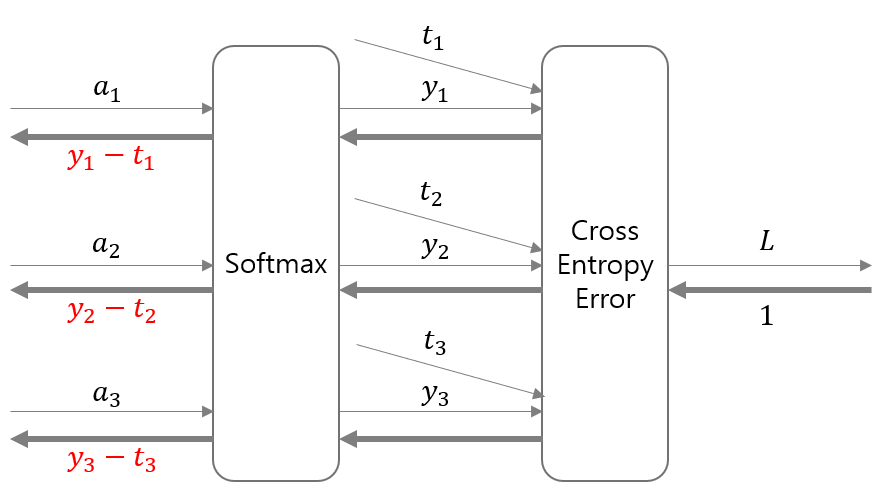

In [35]:
def softmax(a):
  c = np.max(a)
  exp_a = np.exp(a-c)
  sum_exp_a = np.sum(exp_a)
  y = exp_a / sum_exp_a

  return y

def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)

  batch_size = y.shape[0]
  return -np.sum(t*np.log(y + 1e-7)) / batch_size

In [36]:
class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None #손실
    self.y = None #softmax의 출력
    self.t = None #정답 레이블(원-핫 벡터)

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)
    return self.loss

  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    dx = (self.y - self.t) / batch_size

    return dx

### 신경망 학습의 과정 살펴보기
- 1단계 - 미니배치 \
  훈련 데이터 중 일부를 무작위로 가져온다. 이렇게 선별한 데이터를 미니배치라고 하고 해당 미니배치의 손실 함수 값을 줄이는 것이 목표이다.

- 2단계 - 기울기 산출 \
  미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구한다. 기울기는 손실 함수의 값을 가장 작게 하는 방향을 제시한다.

- 3단계 - 매개변수 갱신 \
  가중치 매개변수를 기울기 방향으로 아주 조금 갱신한다.

- 4단계 - 반복 \
  1~3단계를 반복

### 오차역전파법을 적용한 신경망 구현하기


In [37]:
import sys, os
sys.path.append(os.pardir)
import numpy as np

from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:

  def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
    # 가중치 초기화
    self.params = {}
    self.params['W1'] = weight_init_std * \
                        np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * \
                        np.random.randn(input_size, hidden_size)
    self.params['b2'] = np.zeros(hidden_size)

    #계층 생성
    self.layers = OrderedDict()
    self.layers['Affine1'] = \
        Affine(self.params['W1'], self.params['b1'])
    self.layers['Relu1'] = Relu()
    self.layers['Affine2'] = \
        Affine(self.params['W2'], self.params['b2'])

    self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
      for layer in self.layers.values():
        x = layer.forward(x)

      return x

    # x: 입력데이터, t: 정답 레이블
    def loss(self, x, t):
      y = self.predict(x)
      return self.lastLayer.forward(y, t)


    def accuracy(self, x, t):
      y = self.predict(x)
      y = np.argmax(y, axis=1)
      if t.ndim != 1 : t = np.argmax(t, axis = 1)

      accuracy = np.sum(y == t) / float(x.shape[0])

      return accuracy

    # x: 입력 데이터, t: 정답 레이블
    def numerical_gradient(self, x, t):
      loss_W = lambda W: self.loss(x, t)

      grads = {}
      grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
      grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
      grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
      grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

    def gradient(self, x, t):
      #순전파
      self.loss(x, t)

      #역전파
      dout = 1
      dout = self.lastLayer.backward(dout)

      layers = list(self.layers.values())
      layers.reverse()
      for layer in layers:
        dout = layer.backward(dout)

      #결과저장
      grads = {}
      grads['W1'] = self.layers['Affine1'].dW
      grads['b1'] = self.layers['Affine1'].db
      grads['W2'] = self.layers['Affine2'].dW
      grads['b2'] = self.layers['Affine2'].db

      return grads

### 오차역전파법으로 구한 기울기 검증하기
- 수치 미분의 결과와 오차역전파법으로 구한 기울기 결과가 일치함을 확인하는 작업을 기울기 확인이라고 한다.


In [38]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 각 가중치의 절대 오차의 평균을 구한다.
for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:4.2440189846997244e-10
b1:2.337720290862045e-09
W2:6.775383304819785e-09
b2:1.4015603312517166e-07


### 오차역전파법을 사용한 학습 구현하기


In [39]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)

import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch) # 수치 미분 방식
    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식(훨씬 빠르다)

    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

0.10998333333333334 0.1099
0.9038166666666667 0.9088
0.92345 0.9263
0.9363833333333333 0.9363
0.9429666666666666 0.9428
0.9485666666666667 0.9454
0.9535666666666667 0.9528
0.9592 0.9556
0.9615666666666667 0.9573
0.9640666666666666 0.9599
0.9667333333333333 0.9624
0.9674666666666667 0.9633
0.9718833333333333 0.966
0.9731833333333333 0.9671
0.97475 0.9683
0.97595 0.9684
0.97795 0.9686
